In [1]:
import tqdm
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 10})
import torch

In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import priors
import updates
import utils

In [3]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

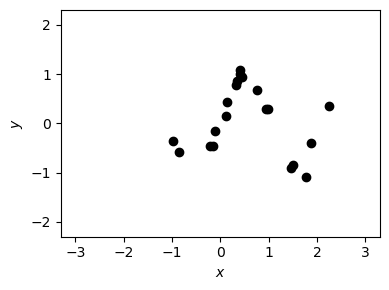

In [4]:
N = 20
X_numpy = np.random.randn(N)
y_numpy = np.sin(3 * X_numpy) + 0.1 * np.random.randn(N)

#N = 20
#X_numpy = np.random.randn(N, 1)
#K = utils.rbf_kernel(X_numpy, X_numpy, lengthscale=0.25, outputscale=0.5)
#y_numpy = np.random.multivariate_normal(mean=np.zeros(N), cov=K, size=1) + 0.1 * np.random.randn(N)

X = torch.tensor(X_numpy.reshape(-1, 1), dtype=torch.float64)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float64)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.scatter(X_numpy, y_numpy, color="#000000")
ax.set_xlim([-3.3, 3.3])
ax.set_ylim([-2.3, 2.3])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

fig.tight_layout()
plt.show()

In [5]:
phi = layers.RandomFourierFeatures(in_features=1, learnable_lengthscale=True, learnable_outputscale=True, lengthscale=1.0, outputscale=1.0, rank=1_024)
init_state_dict = copy.deepcopy(phi.state_dict())


In [6]:
num_epochs = 1_000
lrs = [0.1, 0.01, 0.001, 0.0001]

best_checkpoint = None
elbos = torch.full(size=(len(lrs), num_epochs), fill_value=float("-inf"))
lmls = torch.full(size=(len(lrs), num_epochs), fill_value=float("-inf"))

for i, lr in enumerate(lrs):

    phi = layers.RandomFourierFeatures(in_features=1, learnable_lengthscale=True, learnable_outputscale=True, lengthscale=1.0, outputscale=1.0, rank=1_024)
    phi.load_state_dict(init_state_dict)

    eps = torch.tensor(1e-6, dtype=torch.float64)
    sigma_y2_star = torch.tensor(1.0, dtype=torch.float64)
    tau = torch.tensor(1.0, dtype=torch.float64)
    temp = torch.tensor(1.0, dtype=torch.float64)

    optimizer = torch.optim.Adam(phi.parameters(), lr=lr)
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    for j in tqdm.tqdm(range(num_epochs)):

        # Coordinate ascent updates
        with torch.no_grad():
            Phi = phi(X)
            v_q_star = updates.rank1_v_q_update(eps, Phi, tau=tau, temp=temp)
            mu_q_star = updates.rank1_mu_q_update(Phi, sigma_y2_star, y, tau=tau, temp=temp)
            sigma_y2_star = updates.rank1_sigma_y2_update(eps, mu_q_star, Phi, v_q_star, y)

        # Gradient descent updates
        optimizer.zero_grad()
        Phi = phi(X)
        elbo = utils.rank1_elbo(eps, mu_q_star, Phi, sigma_y2_star, v_q_star, y, tau=tau, temp=temp)
        (-elbo).backward()
        optimizer.step()
        
        lr_scheduler.step()

        with torch.no_grad():
            lml = utils.lml(Phi, sigma_y2_star, y, tau=tau)
            
        elbos[i,j] = elbo.item()
        lmls[i,j] = lml.item()

        if elbo.item() >= elbos.max():
            best_checkpoint = {
                "eps": copy.deepcopy(eps.detach()),
                "mu_q_star": copy.deepcopy(mu_q_star.detach()),
                "phi": copy.deepcopy(phi.state_dict()),
                "sigma_y2_star": copy.deepcopy(sigma_y2_star.detach()),
                "v_q_star": copy.deepcopy(v_q_star.detach()),
                "tau": copy.deepcopy(tau.detach()),
                "temp": copy.deepcopy(temp.detach()),
            }


100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


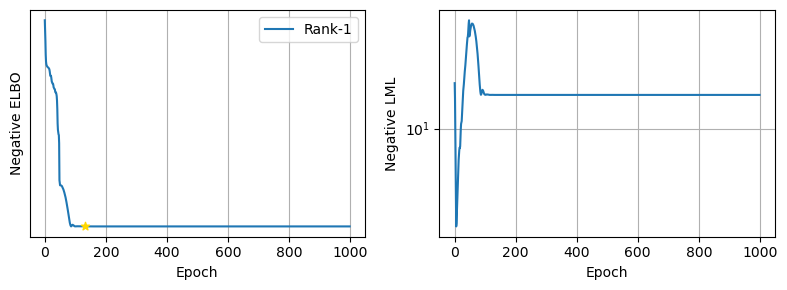

In [7]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[0].plot(range(len(elbos[0])), -elbos[0], label="Rank-1")
axs[0].scatter((-elbos[0]).argmin(), (-elbos[0]).min(), color="gold", marker="*", zorder=2)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Negative ELBO")
axs[0].set_yscale("symlog")
axs[0].legend()
axs[0].grid()

axs[1].plot(range(len(lmls[0])), -lmls[0])
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Negative LML")
axs[1].set_yscale("symlog")
axs[1].grid()

fig.tight_layout()

plt.show()


In [8]:
# Load best checkpoint
eps = best_checkpoint["eps"]
mu_q_star = best_checkpoint["mu_q_star"]
phi.load_state_dict(best_checkpoint["phi"])
sigma_y2_star = best_checkpoint["sigma_y2_star"]
v_q_star = best_checkpoint["v_q_star"]
tau = best_checkpoint["tau"]
temp = best_checkpoint["temp"]
# Save hyperparameters
rank1_likelihood_variance = sigma_y2_star.item()
rank1_lengthscale = phi.lengthscale.item()
rank1_outputscale = phi.outputscale.item()
# Calculate ELBO and LML
with torch.no_grad():
    Phi = phi(X)
    rank1_elbo = utils.rank1_elbo(eps, mu_q_star, Phi, sigma_y2_star, v_q_star, y, tau=tau, temp=temp).item()
    rank1_lml = utils.lml(Phi, sigma_y2_star, y, tau=tau).item()

In [9]:
X_star = torch.linspace(start=-3.3, end=3.3, steps=1_000, dtype=torch.float64).view(-1, 1)
Phi_star = phi(X_star)

with torch.no_grad():
    
    Sigma_q = v_q_star @ v_q_star.T + eps * torch.eye(n=phi.rank, dtype=torch.float64)
    L_q = torch.linalg.cholesky(Sigma_q)
    posterior = torch.distributions.multivariate_normal.MultivariateNormal(mu_q_star.view(-1), scale_tril=L_q)
    
    rank1_mean = Phi_star @ mu_q_star
    
    rank1_samples = []
    for _ in tqdm.tqdm(range(10_000)):
        rank1_samples.append(Phi_star @ posterior.sample() + torch.sqrt(sigma_y2_star).item() * torch.randn(size=(1_000,), dtype=torch.float64))
    rank1_samples = torch.stack(rank1_samples)
    
    rank1_posterior_samples = []
    for _ in tqdm.tqdm(range(3)):
        rank1_posterior_samples.append(Phi_star @ posterior.sample())
    rank1_posterior_samples = torch.stack(rank1_posterior_samples)
    

100%|██████████| 3/3 [00:00<00:00, 1303.66it/s]


In [10]:
num_epochs = 1_000
lrs = [0.1, 0.01, 0.001, 0.0001]

best_checkpoint = None
elbos = torch.full(size=(len(lrs), num_epochs), fill_value=float("-inf"))
lmls = torch.full(size=(len(lrs), num_epochs), fill_value=float("-inf"))

for i, lr in enumerate(lrs):

    phi = layers.RandomFourierFeatures(in_features=1, learnable_lengthscale=True, learnable_outputscale=True, lengthscale=1.0, outputscale=1.0, rank=1_024)
    phi.load_state_dict(init_state_dict)

    eps = torch.tensor(1e-6, dtype=torch.float64)
    prior = priors.GaussianPrior(learnable_variance=True, variance=1.0)
    sigma_y2_star = torch.tensor(1.0, dtype=torch.float64)
    temp = torch.tensor(1.0, dtype=torch.float64)
    v_q = torch.nn.Parameter(torch.randn(size=(1_024, 1), dtype=torch.float64))

    optimizer = torch.optim.Adam([{"params": v_q}, {"params": phi.parameters()}, {"params": prior.parameters()}], lr=lr)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    
    for j in tqdm.tqdm(range(num_epochs)):

        # Coordinate ascent updates
        with torch.no_grad():
            Phi = phi(X)
            mu_q_star = updates.rank1_mu_q_update(Phi, sigma_y2_star, y, tau=prior.variance, temp=temp)
            sigma_y2_star = updates.rank1_sigma_y2_update(eps, mu_q_star, Phi, v_q, y)

        # Gradient descent updates
        optimizer.zero_grad()
        Phi = phi(X)
        elbo = utils.rank1_elbo(eps, mu_q_star, Phi, sigma_y2_star, v_q, y, tau=prior.variance, temp=temp)
        (-elbo).backward()
        optimizer.step()
        
        lr_scheduler.step()

        with torch.no_grad():
            lml = utils.lml(Phi, sigma_y2_star, y, tau=prior.variance)
            
        elbos[i,j] = elbo.item()
        lmls[i,j] = lml.item()

        if elbo.item() >= elbos.max():
            best_checkpoint = {
                "eps": copy.deepcopy(eps.detach()),
                "mu_q_star": copy.deepcopy(mu_q_star.detach()),
                "phi": copy.deepcopy(phi.state_dict()),
                "sigma_y2_star": copy.deepcopy(sigma_y2_star.detach()),
                "v_q": copy.deepcopy(v_q.detach()),
                "tau": copy.deepcopy(prior.variance.detach()),
                "temp": copy.deepcopy(temp.detach()),
            }


100%|██████████| 1000/1000 [00:35<00:00, 27.96it/s]


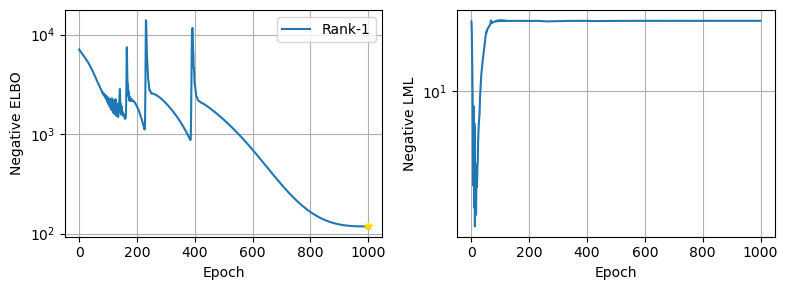

In [11]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[0].plot(range(len(elbos[0])), -elbos[0], label="Rank-1")
axs[0].scatter((-elbos[0]).argmin(), (-elbos[0]).min(), color="gold", marker="*", zorder=2)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Negative ELBO")
axs[0].set_yscale("symlog")
axs[0].legend()
axs[0].grid()

axs[1].plot(range(len(lmls[0])), -lmls[0])
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Negative LML")
axs[1].set_yscale("symlog")
axs[1].grid()

fig.tight_layout()

plt.show()


In [12]:
# Load best checkpoint
eps = best_checkpoint["eps"]
mu_q_star = best_checkpoint["mu_q_star"]
phi.load_state_dict(best_checkpoint["phi"])
sigma_y2_star = best_checkpoint["sigma_y2_star"]
v_q = best_checkpoint["v_q"]
tau = best_checkpoint["tau"]
temp = best_checkpoint["temp"]
# Save hyperparameters
eb_rank1_likelihood_variance = sigma_y2_star.item()
eb_rank1_lengthscale = phi.lengthscale.item()
eb_rank1_outputscale = phi.outputscale.item()
eb_rank1_tau = tau.item()
# Calculate ELBO and LML
with torch.no_grad():
    Phi = phi(X)
    eb_rank1_elbo = utils.rank1_elbo(eps, mu_q_star, Phi, sigma_y2_star, v_q, y, tau=tau, temp=temp).item()
    eb_rank1_lml = utils.lml(Phi, sigma_y2_star, y, tau=tau).item()

In [13]:
X_star = torch.linspace(start=-3.3, end=3.3, steps=1_000, dtype=torch.float64).view(-1, 1)
Phi_star = phi(X_star)

with torch.no_grad():
    
    Sigma_q = v_q @ v_q.T + eps * torch.eye(n=phi.rank, dtype=torch.float64)
    L_q = torch.linalg.cholesky(Sigma_q)
    posterior = torch.distributions.multivariate_normal.MultivariateNormal(mu_q_star.view(-1), scale_tril=L_q)
    
    eb_rank1_mean = Phi_star @ mu_q_star
    
    eb_rank1_samples = []
    for _ in tqdm.tqdm(range(10_000)):
        eb_rank1_samples.append(Phi_star @ posterior.sample() + torch.sqrt(sigma_y2_star).item() * torch.randn(size=(1_000,), dtype=torch.float64))
    eb_rank1_samples = torch.stack(eb_rank1_samples)
    
    eb_rank1_posterior_samples = []
    for _ in tqdm.tqdm(range(3)):
        eb_rank1_posterior_samples.append(Phi_star @ posterior.sample())
    eb_rank1_posterior_samples = torch.stack(eb_rank1_posterior_samples)
    

100%|██████████| 3/3 [00:00<00:00, 722.99it/s]


In [14]:
num_epochs = 1_000
lrs = [0.1, 0.01, 0.001, 0.0001]

best_checkpoint = None
elbos = torch.full(size=(len(lrs), num_epochs), fill_value=float("-inf"))
lmls = torch.full(size=(len(lrs), num_epochs), fill_value=float("-inf"))

for i, lr in enumerate(lrs):

    phi = layers.RandomFourierFeatures(in_features=1, learnable_lengthscale=True, learnable_outputscale=True, lengthscale=1.0, outputscale=1.0, rank=1_024)
    phi.load_state_dict(init_state_dict)

    sigma_y2_star = torch.tensor(1.0, dtype=torch.float64)
    tau = torch.tensor(1.0, dtype=torch.float64)
    temp = torch.tensor(1.0, dtype=torch.float64)

    optimizer = torch.optim.Adam(phi.parameters(), lr=lr)
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    for j in tqdm.tqdm(range(num_epochs)):

        # Coordinate ascent updates
        with torch.no_grad():
            Phi = phi(X)
            mu_q_star = updates.fullrank_mu_q_update(Phi, sigma_y2_star, y, tau=tau, temp=temp)
            Sigma_q_star = updates.fullrank_Sigma_q_update(Phi, sigma_y2_star, tau=tau, temp=temp)
            sigma_y2_star = updates.fullrank_sigma_y2_update(mu_q_star, Phi, Sigma_q_star, y)

        # Gradient descent updates
        optimizer.zero_grad()
        Phi = phi(X)
        elbo = utils.fullrank_elbo(mu_q_star, Phi, Sigma_q_star, sigma_y2_star, y, tau=tau, temp=temp)
        (-elbo).backward()
        optimizer.step()
        
        lr_scheduler.step()

        with torch.no_grad():
            lml = utils.lml(Phi, sigma_y2_star, y, tau=tau)
            
        elbos[i,j] = elbo.item()
        lmls[i,j] = lml.item()

        if elbo.item() >= elbos.max():
            best_checkpoint = {
                "mu_q_star": copy.deepcopy(mu_q_star.detach()),
                "phi": copy.deepcopy(phi.state_dict()),
                "Sigma_q_star": copy.deepcopy(Sigma_q_star.detach()),
                "sigma_y2_star": copy.deepcopy(sigma_y2_star.detach()),
                "tau": copy.deepcopy(tau.detach()),
                "temp": copy.deepcopy(temp.detach()),
            }


100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]


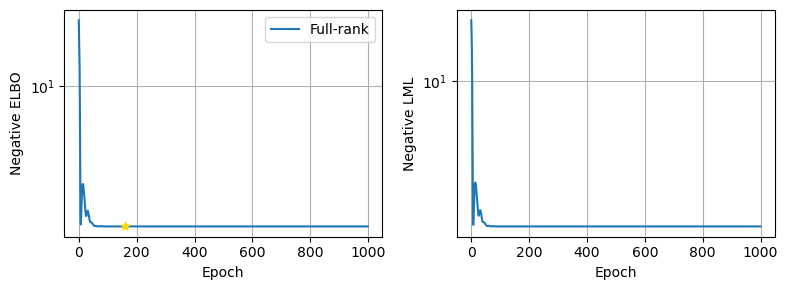

In [15]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[0].plot(range(len(elbos[0])), -elbos[0], label="Full-rank")
axs[0].scatter((-elbos[0]).argmin(), (-elbos[0]).min(), color="gold", marker="*", zorder=2)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Negative ELBO")
axs[0].set_yscale("symlog")
axs[0].legend()
axs[0].grid()

axs[1].plot(range(len(lmls[0])), -lmls[0])
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Negative LML")
axs[1].set_yscale("symlog")
axs[1].grid()

fig.tight_layout()

plt.show()


In [16]:
# Load best checkpoint
mu_q_star = best_checkpoint["mu_q_star"]
phi.load_state_dict(best_checkpoint["phi"])
Sigma_q_star = best_checkpoint["Sigma_q_star"]
sigma_y2_star = best_checkpoint["sigma_y2_star"]
tau = best_checkpoint["tau"]
temp = best_checkpoint["temp"]
# Save hyperparameters
fullrank_likelihood_variance = sigma_y2_star.item()
fullrank_lengthscale = phi.lengthscale.item()
fullrank_outputscale = phi.outputscale.item()
# Calculate ELBO and LML
with torch.no_grad():
    Phi = phi(X)
    fullrank_elbo = utils.fullrank_elbo(mu_q_star, Phi, Sigma_q_star, sigma_y2_star, y, tau=tau, temp=temp).item()
    fullrank_lml = utils.lml(Phi, sigma_y2_star, y, tau=tau).item()

In [17]:
X_star = torch.linspace(start=-3.3, end=3.3, steps=1_000, dtype=torch.float64).view(-1, 1)
Phi_star = phi(X_star)

with torch.no_grad():
    
    L_q = torch.linalg.cholesky(Sigma_q_star)
    posterior = torch.distributions.multivariate_normal.MultivariateNormal(mu_q_star.view(-1), scale_tril=L_q)
    
    fullrank_mean = Phi_star @ mu_q_star
    
    fullrank_samples = []
    for _ in tqdm.tqdm(range(10_000)):
        fullrank_samples.append(Phi_star @ posterior.sample() + torch.sqrt(sigma_y2_star).item() * torch.randn(size=(1_000,), dtype=torch.float64))
    fullrank_samples = torch.stack(fullrank_samples)
    

100%|██████████| 10000/10000 [00:06<00:00, 1487.09it/s]


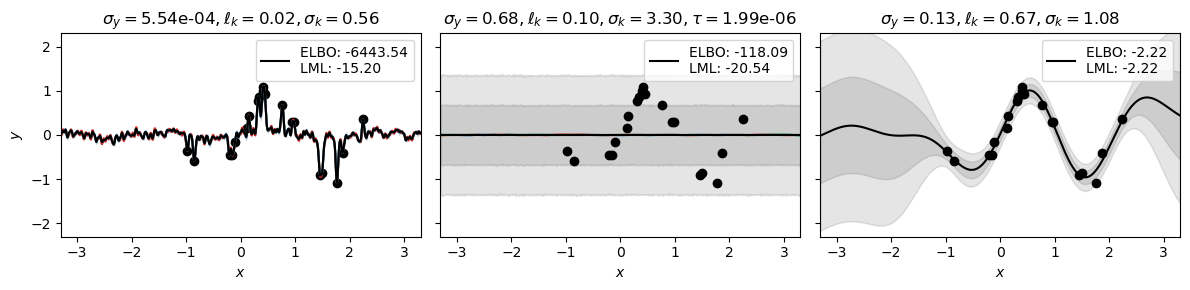

In [33]:
linspace = np.linspace(start=-3.3, stop=3.3, num=1000)

ncols, nrows = 3, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey="row")

axs[0].scatter(X_numpy, y_numpy, color="#000000")
axs[0].fill_between(linspace, rank1_samples.mean(dim=0) + 2 * rank1_samples.std(dim=0), rank1_samples.mean(dim=0) - 2 * rank1_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].fill_between(linspace, rank1_samples.mean(dim=0) + 1 * rank1_samples.std(dim=0), rank1_samples.mean(dim=0) - 1 * rank1_samples.std(dim=0), alpha=0.1, color="#000000")
axs[0].plot(linspace, rank1_posterior_samples[0], color="#2CA02C")
axs[0].plot(linspace, rank1_posterior_samples[1], color="#D62728")
axs[0].plot(linspace, rank1_posterior_samples[2], color="#1F77B4")
axs[0].plot(linspace, rank1_mean, color="#000000", label=f"ELBO: {rank1_elbo:.2f}\nLML: {rank1_lml:.2f}")
axs[0].set_xlim([-3.3, 3.3])
axs[0].set_ylim([-2.3, 2.3])
axs[0].set_title(rf"$\sigma_y=${np.sqrt(rank1_likelihood_variance):.2e}$, \ell_k={rank1_lengthscale:.2f}, \sigma_k={rank1_outputscale:.2f}$")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$y$")
axs[0].legend(loc="upper right")

axs[1].scatter(X_numpy, y_numpy, color="#000000")
axs[1].fill_between(linspace, eb_rank1_samples.mean(dim=0) + 2 * eb_rank1_samples.std(dim=0), eb_rank1_samples.mean(dim=0) - 2 * eb_rank1_samples.std(dim=0), alpha=0.1, color="#000000")
axs[1].fill_between(linspace, eb_rank1_samples.mean(dim=0) + 1 * eb_rank1_samples.std(dim=0), eb_rank1_samples.mean(dim=0) - 1 * eb_rank1_samples.std(dim=0), alpha=0.1, color="#000000")
axs[1].plot(linspace, eb_rank1_posterior_samples[0], color="#2CA02C")
axs[1].plot(linspace, eb_rank1_posterior_samples[1], color="#D62728")
axs[1].plot(linspace, eb_rank1_posterior_samples[2], color="#1F77B4")
axs[1].plot(linspace, eb_rank1_mean, color="#000000", label=f"ELBO: {eb_rank1_elbo:.2f}\nLML: {eb_rank1_lml:.2f}")
axs[1].set_xlim([-3.3, 3.3])
axs[1].set_ylim([-2.3, 2.3])
axs[1].set_title(rf"$\sigma_y={np.sqrt(eb_rank1_likelihood_variance):.2f}, \ell_k={eb_rank1_lengthscale:.2f}, \sigma_k={eb_rank1_outputscale:.2f}, \tau=${eb_rank1_tau:.2e}")
axs[1].set_xlabel(r"$x$")
axs[1].legend(loc="upper right")

axs[2].scatter(X_numpy, y_numpy, color="#000000")
axs[2].fill_between(linspace, fullrank_samples.mean(dim=0) + 2 * fullrank_samples.std(dim=0), fullrank_samples.mean(dim=0) - 2 * fullrank_samples.std(dim=0), alpha=0.1, color="#000000")
axs[2].fill_between(linspace, fullrank_samples.mean(dim=0) + 1 * fullrank_samples.std(dim=0), fullrank_samples.mean(dim=0) - 1 * fullrank_samples.std(dim=0), alpha=0.1, color="#000000")
axs[2].plot(linspace, fullrank_mean, color="#000000", label=f"ELBO: {fullrank_elbo:.2f}\nLML: {fullrank_lml:.2f}")
axs[2].set_xlim([-3.3, 3.3])
axs[2].set_ylim([-2.3, 2.3])
axs[2].set_title(rf"$\sigma_y={np.sqrt(fullrank_likelihood_variance):.2f}, \ell_k={fullrank_lengthscale:.2f}, \sigma_k={fullrank_outputscale:.2f}$")
axs[2].set_xlabel(r"$x$")
axs[2].legend(loc="upper right")

fig.tight_layout()
fig.savefig(f"empirical_bayes_{seed}.pdf", bbox_inches="tight")
plt.show()